# Week 13: Poly Square Mapping as a whole
Consider both boundary classification & distortion

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - Intuition of Angle Activation](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [143]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.util import distance_euclidean
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges, retrieve_boundary_vertices
from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_boundary_vertices_related_edges_2D, retrieve_boundary_edges_related_vertices_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
# from util.mesh.triangle.algorithm.R2.mapping_poly_square import Chen_2023

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# Visualization
import pyvista as pv
from pyvista import examples

from scipy.spatial import Delaunay

<a name='1'></a>
## 1 - Test Example

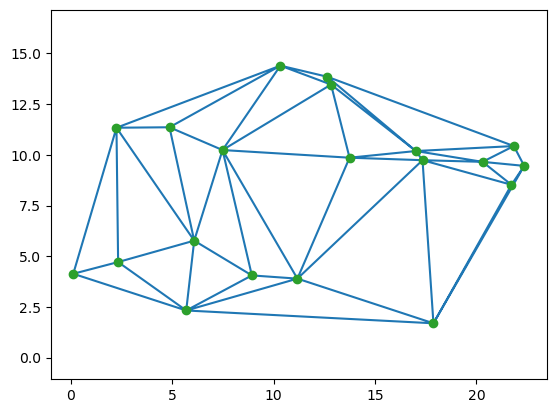

In [136]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=23
points[:, 1]*=15

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

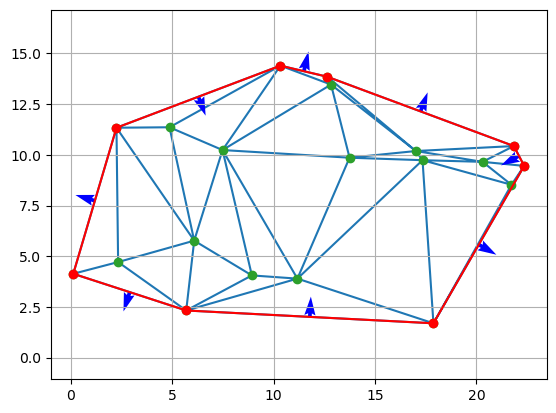

In [137]:
# edges = triangle_edges(tri.simplices)
boundary_vertices = retrieve_boundary_vertices(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)
boundary_angles = retrieve_boundary_angles_2D(boundary_edges, points)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx in boundary_vertices:
    plt.plot(points[idx][0], points[idx][1], 'o', color='red',)
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

# plt.plot(points[monitor_id][0], points[monitor_id][1], 'o', color='black')
plt.axis('equal')
plt.grid() 
plt.show()


In [138]:
faces=tri.simplices.copy()
vertices=points.copy()
boundary_edges = retrieve_boundary_edges(tri.simplices)

<a name='2'></a>
## 2 - The Loss Function

$$Loss = E^A + E^B$$

$E^A$ is the angle term.

$$E^A = \sum_{\theta \in b} activation(\theta)$$

$$
activation(\theta) = 
\begin{cases} 
\frac{\cos^2(\theta)}{\theta} & 0 < \theta < \frac{\pi}{2} \\
\cos^2(\theta) & \frac{\pi}{2} < \theta < \pi
\end{cases}
$$



$E^B$ is the alignment term. The algorithm only measure the alignment of boundary edges.

$$E^B = \sum_{i \in b} L_i(||n_i||-1)$$

$\lambda$ is the hyper-parameter to balance the two terms.

In [120]:
test = Chen_2023(points.copy(), tri.simplices, max_iter = 30)

In [121]:
test.optimize(30)

Round  0  done!
Round  1  done!
Round  2  done!
Round  3  done!
Round  4  done!
Round  5  done!
Round  6  done!
Round  7  done!
Round  8  done!
Round  9  done!
Round  10  done!
Round  11  done!
Round  12  done!
Round  13  done!
Round  14  done!
Round  15  done!
Round  16  done!
Round  17  done!
Round  18  done!
Round  19  done!
Round  20  done!
Round  21  done!
Round  22  done!
Round  23  done!
Round  24  done!
Round  25  done!
Round  26  done!
Round  27  done!
Round  28  done!
Round  29  done!


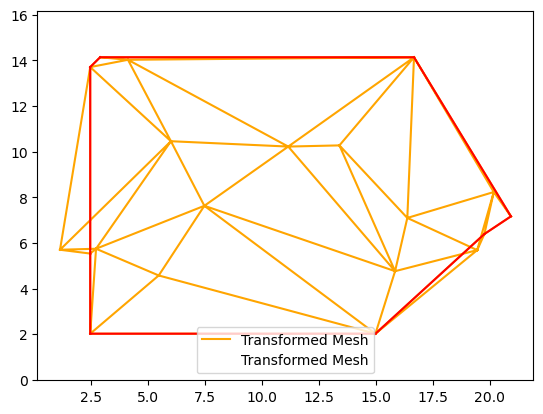

In [123]:
test.v_plt()

<a name='3'></a>
## 3 - Result

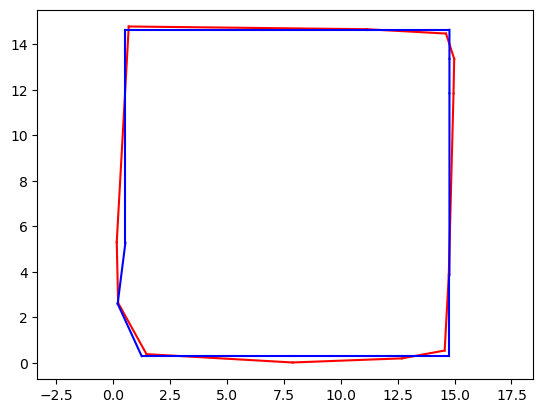

In [23]:
# plt.plot(points[:,0], points[:,1], 'o')
# plt.plot(vertices_designed[:,0], vertices_designed[:,1], 'o', color='red')
# plt.triplot(points[:,0], points[:,1], tri.simplices)
# plt.triplot(vertices_designed[:,0], vertices_designed[:,1], tri.simplices, color='green')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
    plt.plot(test.solution[np.array(edge), 0], test.solution[np.array(edge), 1], 'b-')
plt.axis('equal')
# plt.legend()
plt.show()

In [286]:
def tutte_embedding_2D(vertices, faces, updated_boundary_vertices, boundary_vertices):
    boundary_edges = retrieve_boundary_edges(faces)
    boundary_vertices = retrieve_boundary_vertices(faces)
    
    W = weights_Tutte(vertices, faces, boundary_vertices)
    
    b = np.zeros((len(vertices),2))
    b[boundary_vertices] = updated_boundary_vertices
        
    return spsolve(csr_matrix(W), b)

In [181]:
def weights_Tutte(vertices, faces, boundary_vertices):
    N = len(vertices)
    W = np.zeros((N, N))

    for i, j, k in faces:
        for u, v in [(i, j), (j, k), (k, i)]:
            if u not in boundary_vertices:
                W[u, v] = 1
            if v not in boundary_vertices:
                W[v, u] = 1

    non_boundary_vertices = [i for i in range(N) if i not in boundary_vertices]
    W[non_boundary_vertices] = - W[non_boundary_vertices] / np.sum(W[non_boundary_vertices], axis=1, keepdims=True)
    W += np.eye(N)
    return W

In [182]:
test_v = tutte_embedding_2D(test.vertices, test.faces, test.solution[test.BV_r_V])

In [235]:
class Tutte_1963_2D:
    def __init__(self, vertices, faces, name="default"):
        self.num_vertices = len(vertices)
        self.vertices = vertices
        self.faces = faces
        self.name = name
        
        self.boundary_edges = retrieve_boundary_edges(faces)
        self.boundary_vertices = retrieve_boundary_vertices(faces)
        self.W = weights_Tutte(vertices, faces, self.boundary_vertices)

    def mapping(self, boundary_vertices_coord_updated): 
        b = np.zeros((self.num_vertices,2))
        b[self.boundary_vertices] = boundary_vertices_coord_updated
        
        self.result = spsolve(csr_matrix(self.W), b)
        return self.result
    
    def v_plt(self, show_vertices=False, show_boundary=False, show_origin=False, save_dict=''):
        plt.triplot(self.result[:,0], self.result[:,1], self.faces, label='Transformed Mesh', color='black')
        if show_origin:
            plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='cyan')
        if show_vertices:
            plt.plot(self.result[:,0], self.result[:,1], 'o', color='red')
        if show_boundary:
            for edge in self.boundary_edges:
                plt.plot(self.result[np.array(edge), 0], self.result[np.array(edge), 1], 'r-')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [236]:
map_ = Tutte_1963_2D(test.vertices, test.faces)

In [237]:
new_vertices = map_.mapping(test.solution[test.BV_r_V])

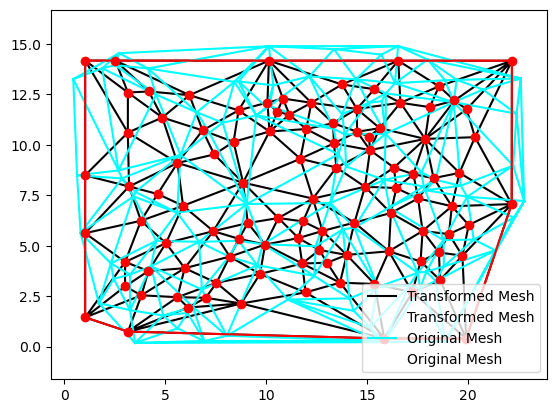

In [238]:
map_.v_plt(show_vertices=True, show_boundary=True, show_origin=True)

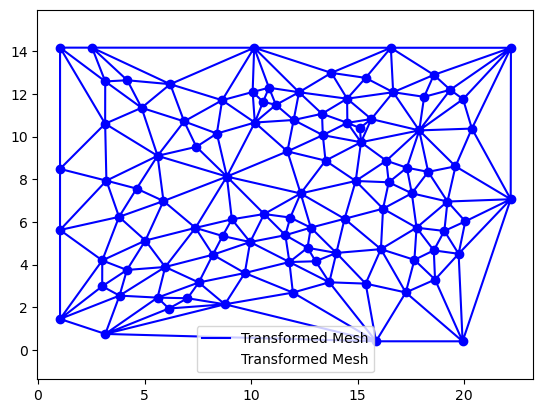

In [234]:
plt.plot(new_vertices[:,0], new_vertices[:,1], 'o', color='blue')
plt.triplot(new_vertices[:,0], new_vertices[:,1], faces, label='Transformed Mesh', color='blue')
for edge in test.BV_r_V:
    plt.plot(test.solution[np.array(edge), 0], test.solution[np.array(edge), 1], 'r-')
plt.axis('equal')
plt.legend()

In [94]:
mesh = pv.read("./mesh/cat.ply")

In [146]:
new_vertices = mesh.points[:, :-1].copy()*10

In [96]:
test1 = Chen_2023(new_vertices, mesh.faces.reshape(-1, 4)[:, 1:], max_iter = 30)

In [97]:
len(test1.BV_r_V)

485

In [103]:
test1.optimize(30)

Round  0  done!
Round  1  done!
Round  2  done!
Round  3  done!
Round  4  done!
Round  5  done!
Round  6  done!
Round  7  done!
Round  8  done!
Round  9  done!
Round  10  done!
Round  11  done!
Round  12  done!
Round  13  done!
Round  14  done!
Round  15  done!
Round  16  done!
Round  17  done!
Round  18  done!
Round  19  done!
Round  20  done!
Round  21  done!
Round  22  done!
Round  23  done!
Round  24  done!
Round  25  done!
Round  26  done!
Round  27  done!
Round  28  done!
Round  29  done!


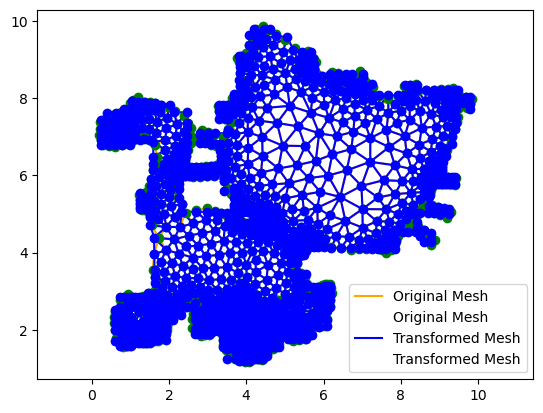

In [112]:
test1.visualize()

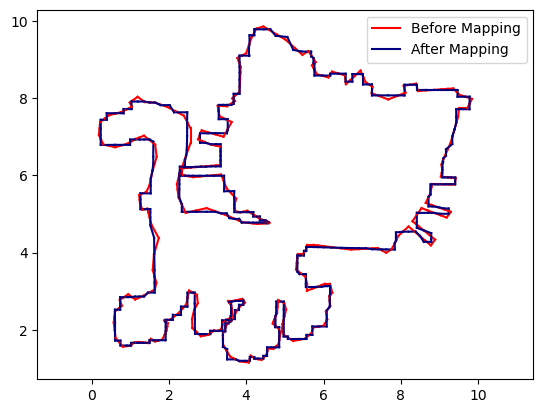

In [283]:
for edge in test1.BE_r_V:
    plt.plot(test1.vertices[np.array(edge), 0], test1.vertices[np.array(edge), 1], color='red')
    plt.plot(test1.solution[np.array(edge), 0], test1.solution[np.array(edge), 1], color='navy')
plt.axis('equal')
plt.plot(test1.vertices[np.array(test1.BE_r_V[0]), 0], test1.vertices[np.array(test1.BE_r_V[0]), 1], label = "Before Mapping", color='red')
plt.plot(test1.solution[np.array(test1.BE_r_V[0]), 0], test1.solution[np.array(test1.BE_r_V[0]), 1], label = "After Mapping",color='navy')

plt.legend()
plt.savefig("./mesh/cat/boundary_compare.png", dpi=300)
plt.show()


In [199]:
test1_map = Tutte_1963(test1.vertices, test1.faces)
t1_res = test1_map.mapping(test1.solution[test1.BV_r_V])

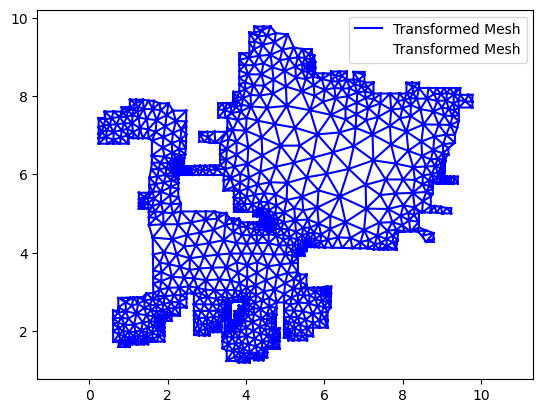

In [120]:
plt.plot(t1_res[:,0], new_vertices[:,1], 'o', color='blue')
plt.triplot(t1_res[:,0], t1_res[:,1], test1.faces, label='Transformed Mesh', color='blue')
# for edge in test.boundary_edges:
#     plt.plot(test.solution[np.array(edge), 0], test.solution[np.array(edge), 1], 'r-')
plt.axis('equal')
plt.legend()
plt.show()

In [122]:
def convert_to_pyvista_faces(faces):
    pyvista_faces = np.hstack((3 * np.ones((faces.shape[0], 1), dtype=int), faces))
    return pyvista_faces.flatten()

In [130]:
test_pv_faces = convert_to_pyvista_faces(test1.faces)

In [141]:
new_vertices = np.hstack((t1_res, np.zeros((len(t1_res), 1))))

In [129]:
new_vertices

array([[0.23302688, 7.03444433, 0.        ],
       [0.23501097, 7.20746946, 0.        ],
       [0.23253453, 7.43536139, 0.        ],
       ...,
       [9.77936268, 7.70899391, 0.        ],
       [9.78034019, 7.8531189 , 0.        ],
       [9.78034973, 8.03350258, 0.        ]])

In [1]:
cat_input = pv.PolyData(mesh.points, mesh.faces)

NameError: name 'pv' is not defined

In [ ]:
cat_output = pv.PolyData(mesh.points, mesh.faces)

In [143]:
p2 = pv.Plotter()
# p2.add_mesh(air_plane_update, show_edges=True, color="green", opacity=0.5)
p2.add_mesh(cat, show_edges=True, color="white", opacity=0.5)
p2.add_points(cat.points, color="red", point_size=5)
p2.show()

Widget(value="<iframe src='http://localhost:59361/index.html?ui=P_0x1ca120b5700_2&reconnect=auto' style='width…

In [152]:
cat_input.save('./mesh/cat/cat_input.ply')  

In [127]:
np.zeros((len(t1_res), 1))

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

## 5 - Problems

In [139]:
class Chen_2023:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 30):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BE = retrieve_boundary_vertices_related_edges_2D(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
            return np.power(np.cos(angle), 2) / angle
        else:
            return np.power(np.cos(angle), 2)
        
    def loss_classification(self, x):
        X = x.reshape((len(self.BV_r_V) , 2))
        
        # Boundary alignment
        E_align = 0
        for edge in self.BE_r_BV:
            A, B = X[edge[0]], X[edge[1]]
            E_align += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)
            
        # Boundary angles
        E_angle = 0
        for idx_pairs in self.BV_r_BE:
            p1, p2 = self.BE_r_BV[idx_pairs[0]]
            p3, p4 = self.BE_r_BV[idx_pairs[1]]
            
            edge1 = X[p2] - X[p1] if (p1 == p3 or p1==p4) else X[p1] - X[p2]
            edge2 = X[p4] - X[p3] if (p3 == p1 or p3==p2) else X[p4] - X[p3]

            cos_theta = np.dot(edge1, edge2) / (np.linalg.norm(edge1) * np.linalg.norm(edge2))
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            E_angle += self.activation(angle)
            
#         print(E_align, E_angle)
        
        return self.lambda1*E_align + self.lambda2*E_angle
    
    def optimize_fault(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.loss_classification, x0, options = {'maxiter': self.max_iter}
#                             , method = "BFGS"
                           )
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.loss_classification, x0, options = {'maxiter': 1})
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, save_dict=''):
        plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, label='Transformed Mesh', color='orange')
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'r-')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'r-')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [140]:
test = Chen_2023(vertices, faces, max_iter = 100
                 , lambda1=3
                )

In [141]:
test.optimize(60)

Round  0  done!
Round  1  done!
Round  2  done!
Round  3  done!
Round  4  done!
Round  5  done!
Round  6  done!
Round  7  done!
Round  8  done!
Round  9  done!
Round  10  done!
Round  11  done!
Round  12  done!
Round  13  done!
Round  14  done!
Round  15  done!
Round  16  done!
Round  17  done!
Round  18  done!
Round  19  done!
Round  20  done!
Round  21  done!
Round  22  done!
Round  23  done!
Round  24  done!
Round  25  done!
Round  26  done!
Round  27  done!
Round  28  done!
Round  29  done!
Round  30  done!
Round  31  done!
Round  32  done!
Round  33  done!
Round  34  done!
Round  35  done!
Round  36  done!
Round  37  done!
Round  38  done!
Round  39  done!
Round  40  done!
Round  41  done!
Round  42  done!
Round  43  done!
Round  44  done!
Round  45  done!
Round  46  done!
Round  47  done!
Round  48  done!
Round  49  done!
Round  50  done!
Round  51  done!
Round  52  done!
Round  53  done!
Round  54  done!
Round  55  done!
Round  56  done!
Round  57  done!
Round  58  done!
Round  

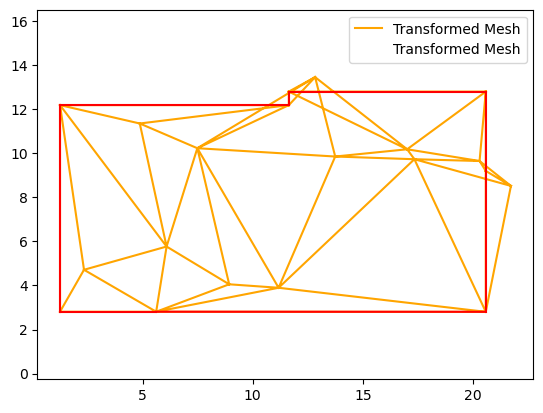

In [142]:
test.v_plt()

In [259]:
def retrieve_boundary_edges_related_vertices_2D(boundary_vertices, boundary_edges):
    BE_r_BV = []
    
    for v1, v2 in boundary_edges:
        idx1 = np.where(boundary_vertices==v1)
        idx2 = np.where(boundary_vertices==v2)
        BE_r_BV.append(np.hstack((idx1[0], idx2[0])))
    
    return np.array(BE_r_BV)

<a name='6'></a>
## 6 - Reference

<!-- <a name='ref-1'></a>
1. [Liu C, Yu W, Chen Z, et al. Distributed poly-square mapping for large-scale semi-structured quad mesh generation[J]. Computer-Aided Design, 2017, 90: 5-17.](https://www.sciencedirect.com/science/article/pii/S0010448517300714?casa_token=JiylsQjWSkQAAAAA:RnbFGyT8qf-EsojvYlxX-if7lhZx1TwO8i0XjTwlYa-y1AqIkVAOJHRwOm5VrxhaAUkET4LSkRc)
<a name='ref-2'></a>
1. [Hormann K, Greiner G. MIPS: An efficient global parametrization method[J]. Curve and Surface Design: Saint-Malo 1999, 2000: 153-162.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=02e4f09c9a6d0d770d31c9289d30b7b4e9b5d974) -->

In [266]:
def preprocess(path, scale=1):
    mesh = pv.read(path)
    vertices = mesh.points[:, :-1].copy()*scale
    faces = mesh.faces.reshape(-1, 4)[:, 1:]
    return vertices, faces

In [267]:
horse_v, horse_f = preprocess("./mesh/horse/horse_input.ply")

In [268]:
horse_test = Chen_2023(horse_v, horse_f)

In [276]:
horse_test.optimize(30)

Round  0  done!
Round  1  done!
Round  2  done!
Round  3  done!
Round  4  done!
Round  5  done!
Round  6  done!
Round  7  done!
Round  8  done!
Round  9  done!
Round  10  done!
Round  11  done!
Round  12  done!
Round  13  done!
Round  14  done!
Round  15  done!
Round  16  done!
Round  17  done!
Round  18  done!
Round  19  done!
Round  20  done!
Round  21  done!
Round  22  done!
Round  23  done!
Round  24  done!
Round  25  done!
Round  26  done!
Round  27  done!
Round  28  done!
Round  29  done!


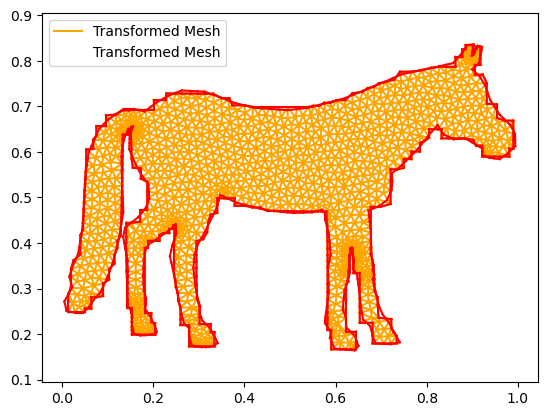

In [277]:
horse_test.v_plt(show_origin=True)

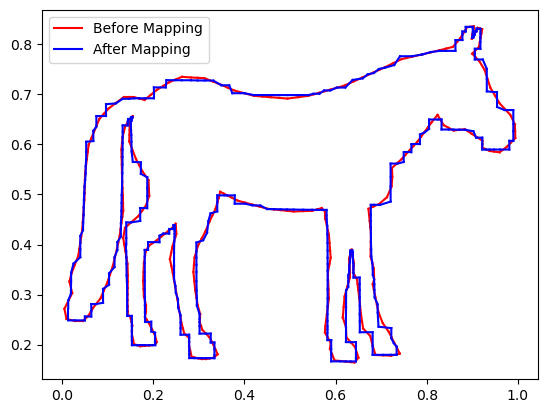

In [282]:
# plt.triplot(horse_test.solution[:,0], horse_test.solution[:,1], horse_test.faces, label='Transformed Mesh', color='orange')
for edge in horse_test.BE_r_V:
    plt.plot(horse_test.vertices[np.array(edge), 0], horse_test.vertices[np.array(edge), 1], 'r-')
for edge in horse_test.BE_r_V:
    plt.plot(horse_test.solution[np.array(edge), 0], horse_test.solution[np.array(edge), 1], 'b-')
    
plt.plot(horse_test.vertices[np.array(horse_test.BE_r_V[0]), 0], horse_test.vertices[np.array(horse_test.BE_r_V[0]), 1], label = "Before Mapping", color='red')
plt.plot(horse_test.solution[np.array(horse_test.BE_r_V[0]), 0], horse_test.solution[np.array(horse_test.BE_r_V[0]), 1], label = "After Mapping", color='blue')
plt.legend()
plt.savefig("./mesh/horse/boundary_compare.png", dpi=300)
plt.show()

In [292]:
horse_solution = tutte_embedding_2D(horse_test.vertices, horse_test.faces, horse_test.solution[horse_test.BV_r_V], horse_test.BE_r_V)

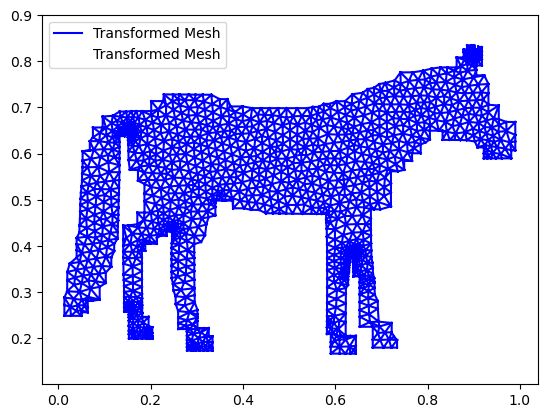

In [295]:
# plt.plot(horse_solution[:,0], horse_solution[:,1], 'o', color='blue')
plt.triplot(horse_solution[:,0], horse_solution[:,1], horse_test.faces, label='Transformed Mesh', color='blue')
# for edge in test.boundary_edges:
#     plt.plot(test.solution[np.array(edge), 0], test.solution[np.array(edge), 1], 'r-')
plt.axis('equal')
plt.legend()
plt.show()

In [293]:
horse_solution

array([[0.01308733, 0.27220559],
       [0.0130874 , 0.24847168],
       [0.01315328, 0.28818202],
       ...,
       [0.9902581 , 0.64060682],
       [0.99014062, 0.62636822],
       [0.9902367 , 0.60713804]])

In [291]:
horse_test.solution[horse_test.BE_r_V]

pyvista_ndarray([[[0.1712773 , 0.19895296],
                  [0.18136951, 0.19899708]],

                 [[0.16455148, 0.19885679],
                  [0.1712773 , 0.19895296]],

                 [[0.15293865, 0.199009  ],
                  [0.16455148, 0.19885679]],

                 ...,

                 [[0.5903997 , 0.19119827],
                  [0.59044534, 0.20921336]],

                 [[0.58203286, 0.22382341],
                  [0.58206224, 0.20911095]],

                 [[0.58206224, 0.20911095],
                  [0.59044534, 0.20921336]]], dtype=float32)

In [301]:
def postprocess(path, vertices, faces):
    pyvista_vertices = np.hstack((vertices, np.zeros((len(vertices), 1))))
    pyvista_faces = np.hstack((3 * np.ones((faces.shape[0], 1), dtype=int), faces))
    pyvista_faces = pyvista_faces.flatten()
    
    output = pv.PolyData(pyvista_vertices, pyvista_faces)
    output.save(path)

In [302]:
postprocess('./mesh/horse/horse_output.ply', horse_solution, horse_test.faces)

In [304]:
elephant_v, elephant_f = preprocess('./mesh/elephant/elephant_input.ply')

In [306]:
elephant_test = Chen_2023(elephant_v, elephant_f)

In [307]:
elephant_test.optimize(30)

Round  0  done!
Round  1  done!
Round  2  done!
Round  3  done!
Round  4  done!
Round  5  done!
Round  6  done!
Round  7  done!
Round  8  done!
Round  9  done!
Round  10  done!
Round  11  done!
Round  12  done!
Round  13  done!
Round  14  done!
Round  15  done!
Round  16  done!
Round  17  done!
Round  18  done!
Round  19  done!
Round  20  done!
Round  21  done!
Round  22  done!
Round  23  done!
Round  24  done!
Round  25  done!
Round  26  done!
Round  27  done!
Round  28  done!
Round  29  done!


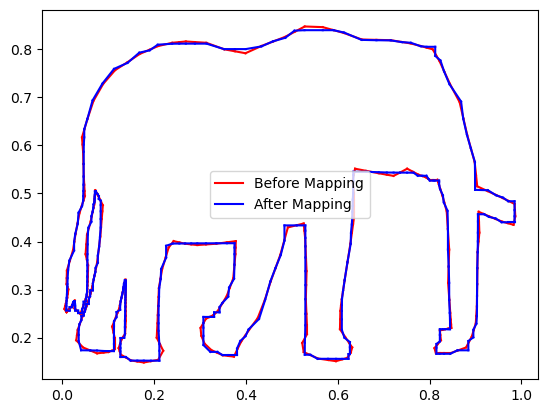

In [308]:
# plt.triplot(horse_test.solution[:,0], horse_test.solution[:,1], horse_test.faces, label='Transformed Mesh', color='orange')
for edge in elephant_test.BE_r_V:
    plt.plot(elephant_test.vertices[np.array(edge), 0], elephant_test.vertices[np.array(edge), 1], 'r-')
for edge in elephant_test.BE_r_V:
    plt.plot(elephant_test.solution[np.array(edge), 0], elephant_test.solution[np.array(edge), 1], 'b-')
    
plt.plot(elephant_test.vertices[np.array(elephant_test.BE_r_V[0]), 0], elephant_test.vertices[np.array(elephant_test.BE_r_V[0]), 1], label = "Before Mapping", color='red')
plt.plot(elephant_test.solution[np.array(elephant_test.BE_r_V[0]), 0], elephant_test.solution[np.array(elephant_test.BE_r_V[0]), 1], label = "After Mapping",color='blue')
plt.legend()
plt.savefig("./mesh/elephant/boundary_compare.png", dpi=300)
plt.show()

In [13]:
import torch

class YourOptimizerClass:
    def __init__(self, BV_r_V, BE_r_BV, BV_r_BE, lambda1=1, lambda2=1):
        self.BV_r_V = BV_r_V
        self.BE_r_BV = BE_r_BV
        self.BV_r_BE = BV_r_BE
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
        # Assuming these arrays are numpy arrays, convert them to torch tensors and move to GPU
        self.BV_r_V = torch.tensor(self.BV_r_V).cuda().float()
        self.BE_r_BV = torch.tensor(self.BE_r_BV).cuda().long()
        self.BV_r_BE = torch.tensor(self.BV_r_BE).cuda().long()

    def activation(self, angle):
        # Assuming some activation function, update it for PyTorch
        return torch.relu(angle)  # Example

    def loss_classification(self, x):
        X = x.reshape((len(self.BV_r_V), 2))
        
        # Boundary alignment
        E_align = 0
        for edge in self.BE_r_BV:
            A, B = X[edge[0]], X[edge[1]]
            E_align += torch.sum(torch.abs(B - A)) - torch.norm(A - B)
            
        # Boundary angles
        E_angle = 0
        for idx_pairs in self.BV_r_BE:
            edge1 = X[idx_pairs[0]] - X[idx_pairs[1]]
            edge2 = X[idx_pairs[1]] - X[idx_pairs[0]]

            cos_theta = torch.dot(edge1, edge2) / (torch.norm(edge1) * torch.norm(edge2))
            angle = torch.acos(torch.clamp(cos_theta, -1.0, 1.0))
            E_angle += self.activation(angle)
            
        return self.lambda1*E_align + self.lambda2*E_angle

# Optimization
x = torch.randn((len(test.BV_r_V), 2), requires_grad=True, device="cuda")
optimizer = torch.optim.LBFGS([x], lr=0.01)

def closure():
    optimizer.zero_grad()
    loss = YourOptimizerClass(test.BV_r_V, test.BE_r_BV, test.BV_r_BE, lambda1, lambda2).loss_classification(x)
    loss.backward()
    return loss



AssertionError: Torch not compiled with CUDA enabled

In [ ]:
for _ in range(100):  # Example number of iterations
    optimizer.step(closure)